In [23]:
from datetime import datetime, date

def parse_datetime(date):
  return datetime.strptime(date.split('-')[0].strip(), "%d.%m.%Y %H:%M")

print(parse_datetime("18.11.2023 06:00 - 18.11.2023"))


2023-11-18 06:00:00


Index(['datetime', 'date', 'hour', 'eur_per_mwh'], dtype='object')
                            datetime         hour  eur_per_mwh
count                           6863  6863.000000  6863.000000
mean   2023-05-23 23:42:21.454174720    11.501384    53.650363
min              2023-01-01 00:00:00     0.000000   -60.040000
25%              2023-03-13 11:30:00     6.000000    15.215000
50%              2023-05-24 00:00:00    12.000000    40.480000
75%              2023-08-03 11:30:00    17.500000    80.900000
max              2023-10-13 23:00:00    23.000000   549.950000
std                              NaN     6.922245    50.410970
Index(['datetime', 'date', 'hour', 'kwh'], dtype='object')
                            datetime         hour          kwh
count                           6854  6854.000000  6854.000000
mean   2023-05-23 21:12:20.589436928    11.495769     2.258898
min              2023-01-01 02:00:00     0.000000     0.000000
25%              2023-03-13 11:15:00     6.000000     0

<Axes: xlabel='datetime'>

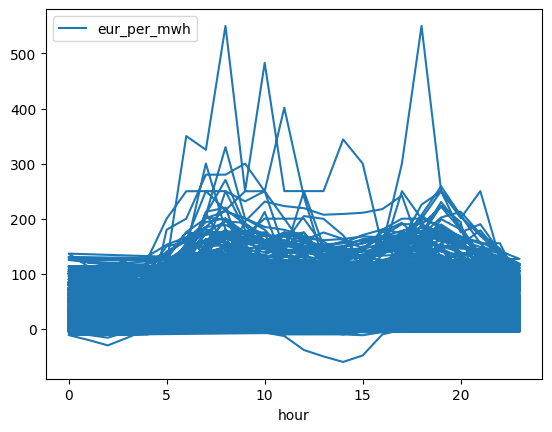

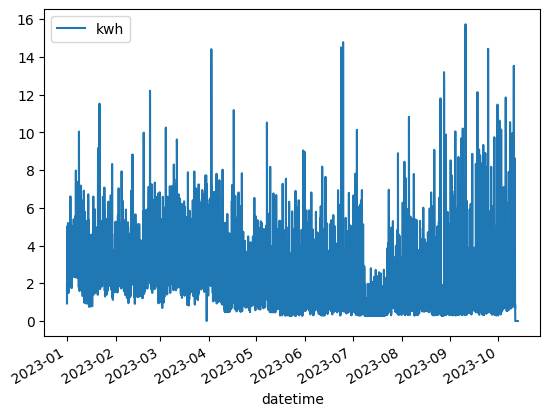

In [24]:
import csv
import matplotlib.pyplot as plt
import pandas as pandas
from dataclasses import dataclass

@dataclass
class PriceEntry:
    datetime: datetime
    date: date
    hour: int
    eur_per_mwh: float

@dataclass
class ConsumptionEntry:
   datetime: datetime
   date: date
   hour: int
   kwh: float


def load_prices():
    with open('prices.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader) #ignore header
        for row in reader:
            [date, price] = row[0:2]
            try:
              d = parse_datetime(date).replace(tzinfo=None)
              yield PriceEntry(datetime=d, date=d.date(),hour=d.hour, eur_per_mwh=float(price))
            except ValueError:
              pass    

def load_consumption():
   with open('consumption.csv') as csvfile:
      reader = csv.reader(csvfile, delimiter=",")
      next(reader) #ignore header
      for row in reader:
          [date, consumption] = row[0:2]
          try:
            d = datetime.fromisoformat(date).replace(tzinfo=None)
            yield ConsumptionEntry(datetime=d, date=d.date(),hour=d.hour, kwh=float(consumption))
          except ValueError:
            pass    

dataset = pandas.DataFrame(data=load_prices())
dataset.index = dataset["datetime"]

consumption = pandas.DataFrame(data=load_consumption())
consumption.index = consumption['datetime']


print(dataset.columns)
print(dataset.describe())

print(consumption.columns)
print(consumption.describe())

dataset.plot('hour', 'eur_per_mwh')

consumption.plot('datetime', 'kwh')

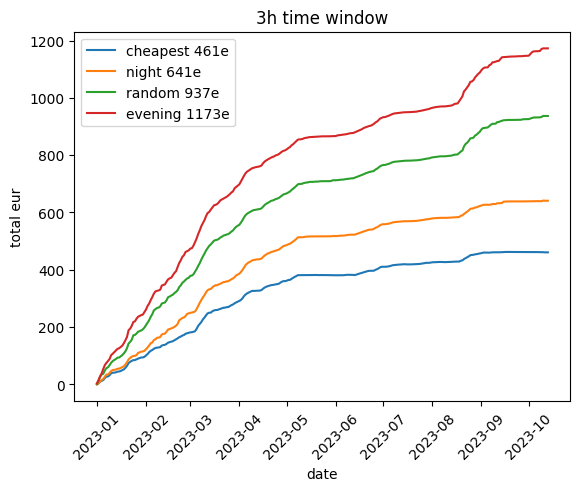

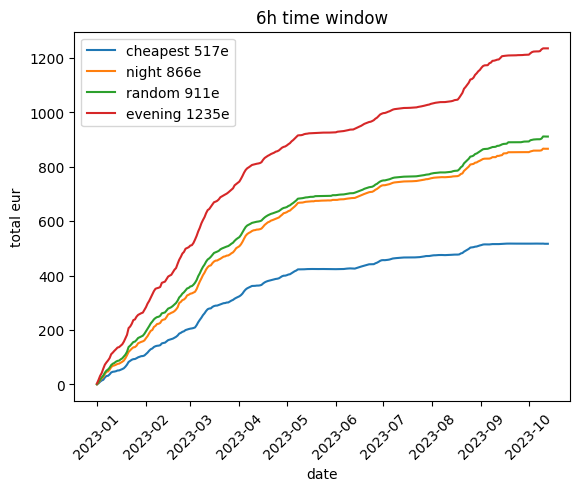

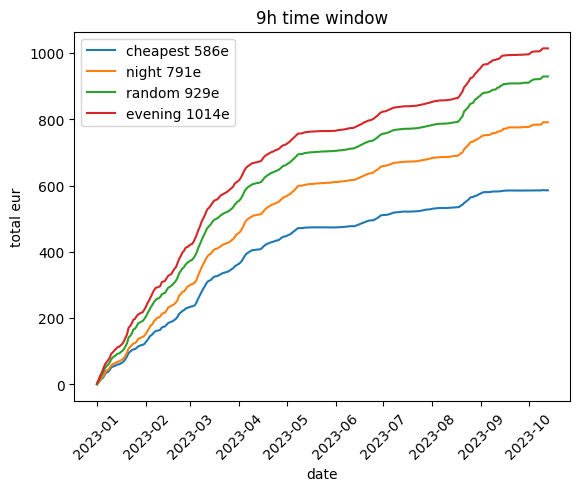

In [25]:

import math
from datetime import time

bydate = dataset.groupby("date")

def get_total(sampler, nhours):
    result = pandas.DataFrame(columns=["date", "cost"])
    for idx,[date, values] in enumerate(bydate):
        values.index = values["datetime"]
        sample = sampler(values)
        total_for_the_day_kwh = consumption[datetime.combine(date, time.min).replace(tzinfo=None):datetime.combine(date, time.max).replace(tzinfo=None)]["kwh"].sum()
        power_mw = (total_for_the_day_kwh/nhours)/1000
        result.loc[idx] = {"date": date, "cost": sum(sample["eur_per_mwh"] * power_mw)}
    return result


for nhours in [3, 6, 9]:
    cheapest = get_total(lambda x: x.nsmallest(nhours,columns="eur_per_mwh"), nhours)
    random = get_total(lambda x: x.sample(nhours), nhours)
    night = get_total(lambda x: x.between_time(f"{4 - math.floor(nhours/2)}:00", f"{4 + math.floor(nhours/2)}:00"), nhours)
    evening = get_total(lambda x: x.between_time(f"{18 - math.floor(nhours/2)}:00", f"{18 + math.floor(nhours/2)}:00"), nhours)
    plt.title(f"{nhours}h time window")

    plt.xlabel("date")
    plt.ylabel("total eur")
    plt.xticks(rotation=45)

    def plot_dataset(dataset, label):
        total = dataset['cost'].sum()
        plt.plot(dataset["date"], dataset["cost"].cumsum(), label=f'{label} {round(total)}e')    

    plot_dataset(cheapest, "cheapest")
    plot_dataset(night, "night")
    plot_dataset(random, "random")
    plot_dataset(evening, "evening")
    plt.legend()
    plt.show()





